In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv


**Loading Libraries**

In [2]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

**Loading Data**

In [3]:
test_I = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_T = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
train_I = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_T = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

**Memory Reduction Function**

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Applying Memory Reduction**

In [5]:
test_I = reduce_mem_usage(test_I)
test_T = reduce_mem_usage(test_T)
train_I = reduce_mem_usage(train_I)
train_T = reduce_mem_usage(train_T)

Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.86 MB
Decreased by 77.8%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


After memory reduction you can see, memory uses of dataframe decreased by morer than 70%.

**EDA**

In [6]:
print('                Identity   Transaction')
print('train shape :'+str(train_I.shape)+ ' ' +str(train_T.shape) )
print('test shape  :'+str(test_I.shape)+ ' ' +str(test_T.shape) )

                Identity   Transaction
train shape :(144233, 41) (590540, 394)
test shape  :(141907, 41) (506691, 393)


We can see above that no. of rows are different in both Identity and Transaction dataset so it means that when we will merge these two datasets, there will be many rows having NaN values for Identity Columns.

**Merging Identity & Transaction Data Sets**

Here,we are using merge function insted of conat function because the values present in TransactionID_x column of both datasets are not corresponds to each other.

In [7]:
train = train_T.merge(train_I, how='left', left_index=True, right_index=True)
test = test_T.merge(test_I, how='left', left_index=True, right_index=True)

train_Tran_ID = train['TransactionID_x'].copy()
test_Tran_ID = test['TransactionID_x'].copy()

print('train shape :'+str(train.shape))
print('test shape  :'+str(test.shape))
del train_I
del train_T
del test_I
del test_T
gc.collect()

train shape :(590540, 435)
test shape  :(506691, 434)


0

Now have a look on our Train and Test Dataset.

In [8]:
print('Train Data Set::')
print(train.head())
print('-------------------------------------------------------------------------------------------------')
print('\nTest Data Set::')
print(test.head())

Train Data Set::
   TransactionID_x  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0          2987000        0          86400            68.5         W  13926   
1          2987001        0          86401            29.0         W   2755   
2          2987002        0          86469            59.0         W   4663   
3          2987003        0          86499            50.0         W  18132   
4          2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...  samsung browser 6.2   32.0   
1  404.0  150.0  mastercard  102.0  ...   mobile safari 11.0   32.0   
2  490.0  150.0        visa  166.0  ...          chrome 62.0    NaN   
3  567.0  150.0  mastercard  117.0  ...          chrome 62.0    NaN   
4  514.0  150.0  mastercard  102.0  ...          chrome 62.0   24.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0  2220x108

**Counting Null Values**

Exploring Null values in each columns.

In [9]:
print('Train::')
print(train.isna().sum())
print('--------------------------------------------------------')
print('Test::')
print(test.isna().sum())

Train::
TransactionID_x         0
isFraud                 0
TransactionDT           0
TransactionAmt          0
ProductCD               0
                    ...  
id_36              449555
id_37              449555
id_38              449555
DeviceType         449730
DeviceInfo         471874
Length: 435, dtype: int64
--------------------------------------------------------
Test::
TransactionID_x         0
TransactionDT           0
TransactionAmt          0
ProductCD               0
card1                   0
                    ...  
id_36              369714
id_37              369714
id_38              369714
DeviceType         369760
DeviceInfo         391634
Length: 434, dtype: int64


We can see above that there are huge amount of nan values present in our dataset.

**Separating Target Feature**

Now separating Target feature from Train dataset so that we can merge Train and Test dataset for further exploration.

In [10]:
target = train.isFraud
train = train.drop('isFraud', axis = 1)

**Merging Train & Test**

In [11]:
merge = pd.concat([train,test],axis = 0)

train_len = len(train) # length of Train Dataset. 
test_len = len(test) # length of Test Dataset.

del test
gc.collect()

0

Now creating a Dataframe of NaN value counts in each column of merge dataset.

In [12]:
print('Merge::')
merge_Nan = pd.DataFrame(merge.isna().sum()).reset_index() # merge_Nan DataFrame.
merge_Nan.columns = ['Feature','Nan_Count'] # Column names for merge_Nan DataFrame. 
merge_Nan = merge_Nan.sort_values(by = 'Nan_Count').reset_index(drop = True) # sorting of Non_Count column. 
print(merge_Nan)

Merge::
             Feature  Nan_Count
0    TransactionID_x          0
1      TransactionDT          0
2     TransactionAmt          0
3          ProductCD          0
4              card1          0
..               ...        ...
429            id_08    1087017
430            id_07    1087017
431            id_26    1087021
432            id_25    1087060
433            id_24    1087744

[434 rows x 2 columns]


Now grouping the columns according to the same missing value counts.

In [13]:
Nan_dict = {} # dictionary to store each group.
unique = merge_Nan.Nan_Count.unique() # List of unique NaN value counts.

#Logic to create group and then storing in Nan_dict dictionary with missing value percentage.
for i in unique:
    Nan_dict[str(i)+" :: "+str(100-((len(merge)-i)/len(merge))*100)+'%'] = list(merge_Nan['Feature'][merge_Nan['Nan_Count']==i])
#----------------------

for i,j in Nan_dict.items():
    print(i," : ",'\n',j)
    print('\n')
    
del unique
del Nan_dict
del merge_Nan
gc.collect()

0 :: 0.0%  :  
 ['TransactionID_x', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1']


3 :: 0.0002734155341954647%  :  
 ['C14', 'C12', 'C11', 'C10', 'C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2', 'C9', 'C1']


15 :: 0.0013670776709773236%  :  
 ['V290', 'V320', 'V319', 'V318', 'V317', 'V316', 'V312', 'V311', 'V310', 'V309', 'V308', 'V307', 'V306', 'V279', 'V280', 'V284', 'V286', 'V303', 'V287', 'V302', 'V299', 'V298', 'V321', 'V297', 'V295', 'V294', 'V293', 'V292', 'V291', 'V285', 'V304', 'V305']


314 :: 0.02861749257904478%  :  
 ['V126', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V117', 'V96', 'V116', 'V114', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V115', 'V137', 'V136', 'V95']


4567 :: 0.4162295815557542%  :  
 ['card3']


4578 :: 0.4172321051811281%  :  
 ['card6']


4663 :: 0.42497887864998

0

As we can see in the above output, we have created the groups of columns having same missing value percentage. For example ['C14', 'C12', 'C11', 'C10', 'C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2', 'C9', 'C1']  columns have 3 missing values or in other words we can say that these all columns have ( 0.0002734155341954647% ) missing values.

Now exploring Fraud and Non Fraud rows saperately.

In [14]:
df_all = pd.concat([train,target],axis = 1) # df_all Dataframe is Train dataset 
                                            #with target feature in it.
df_Fraud = df_all[df_all['isFraud']==1] # df_Fraud Dataframe have only those rows which are Fraud.

df = df_all[df_all['isFraud']==0] # df Dataframe have only those rows which are not Fraud.

print('min')
print('Non Fraud :: ',df.isna().sum(axis = 1).min()) # Printing minimum missing values in Non fraud Dataset row-wise.
print('Fraud :: ',df_Fraud.isna().sum(axis = 1).min()) # Printing minimum missing values in fraud Dataset row-wise.
print('max')
print('Non Fraud :: ',df.isna().sum(axis = 1).max()) # Printing maximum missing values in Non fraud Dataset row-wise.
print('Fraud :: ',df_Fraud.isna().sum(axis = 1).max()) # Printing maximum missing values in fraud Dataset row-wise. 

del train
gc.collect()

min
Non Fraud ::  27
Fraud ::  41
max
Non Fraud ::  341
Fraud ::  322


0

I was thought before that there could be a chance that a row may be fraud if it has most of the values are missing. But now as we can see in the output there is not much difference between the missing value count in Fraud and Non Fraud rows so it means my thinking was wrong.

Now next....

Now I am calculating the missing value percentage in each columns of Fraud and NonFraud Dataset saparately.

In [15]:
cols = [] # list of columns
Non_Fraud = [] # list of missing value percentage of Non_Fraud Dataset columns.
Fraud = [] # list of missing value percentage of Fraud Dataset columns.
for col in df.columns:
    Non_Frd = 100-(len(df)-df[col].isna().sum())/len(df)*100
    Frd = 100-(len(df_Fraud)-df_Fraud[col].isna().sum())/len(df_Fraud)*100
    cols.append(col)
    Non_Fraud.append(Non_Frd)
    Fraud.append(Frd)
    print(col,'::','Non-Fraud : ',Non_Frd,'%',' and ','Fraud : ',Frd,'%\n')

TransactionID_x :: Non-Fraud :  0.0 %  and  Fraud :  0.0 %

TransactionDT :: Non-Fraud :  0.0 %  and  Fraud :  0.0 %

TransactionAmt :: Non-Fraud :  0.0 %  and  Fraud :  0.0 %

ProductCD :: Non-Fraud :  0.0 %  and  Fraud :  0.0 %

card1 :: Non-Fraud :  0.0 %  and  Fraud :  0.0 %

card2 :: Non-Fraud :  1.4933046955746647 %  and  Fraud :  2.047137395344336 %

card3 :: Non-Fraud :  0.26777708172114956 %  and  Fraud :  0.18874316410976633 %

card4 :: Non-Fraud :  0.2695318463457994 %  and  Fraud :  0.19842230073076905 %

card5 :: Non-Fraud :  0.710504196519608 %  and  Fraud :  1.016309345206409 %

card6 :: Non-Fraud :  0.2688299404959338 %  and  Fraud :  0.18874316410976633 %

addr1 :: Non-Fraud :  10.171493146766764 %  and  Fraud :  37.46309829163239 %

addr2 :: Non-Fraud :  10.171493146766764 %  and  Fraud :  37.46309829163239 %

dist1 :: Non-Fraud :  59.02378934401634 %  and  Fraud :  76.98785268354062 %

dist2 :: Non-Fraud :  94.05204982829628 %  and  Fraud :  81.94357063349949 %

P_em

The above output shows the missing value percentage in Fraud and NonFraud Dataset for each column.
For example 'card1' column have 0% missing value in Non_fraud Dataset and 0% missing value in Fraud Dataset.

Now I am creating a dataframe using lists ***'cols', 'Non_Fraud', 'Fraud' and 'difference between Fraud and Non_Fraud'***

In [16]:
missing_df = pd.DataFrame([cols,Non_Fraud,Fraud,abs(np.array(Non_Fraud)-np.array(Fraud))])
missing_df = missing_df.transpose()
missing_df.columns = ['Feature','Non_Fraud','Fraud','Diff']
print(missing_df)

del cols
del Non_Fraud
del Fraud
gc.collect()

             Feature Non_Fraud    Fraud     Diff
0    TransactionID_x         0        0        0
1      TransactionDT         0        0        0
2     TransactionAmt         0        0        0
3          ProductCD         0        0        0
4              card1         0        0        0
..               ...       ...      ...      ...
430            id_37   75.9095  82.0984   6.1889
431            id_38   75.9095  82.0984   6.1889
432       DeviceType   75.9399  82.1081  6.16822
433       DeviceInfo   79.7284  84.7892   5.0608
434          isFraud         0        0        0

[435 rows x 4 columns]


0

As we can see in the above output there are 4 columns in the missing_df Dataframe.

Now my next step is finding out those columns which are need to delete from our dataset.
and my logic for this is that I am going to delete those columns from our dataset which have missing value percentage more than 80% in both Fraud and Non_Fraud dataset and the difference between Non_fraud and Fraud missing percentage is less than 5.

If a column have more than 80% missing values so it means that this column is not relivant so need to delete from dataset. 

In [17]:
thresold = 80
diff_per = 5
drop_cols = missing_df['Feature'][np.logical_and(np.logical_and(missing_df['Fraud']>=thresold,
                                                                missing_df['Non_Fraud']>=thresold),
                                                 missing_df['Diff']<diff_per)]
print(list(drop_cols)) # list of columns which are need to delete.
del missing_df
gc.collect()

['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']


0

**Dropping columns**

In [18]:
merge = merge.drop(drop_cols,axis = 1)

**Now Finding Categorical columns**

In [19]:
cat_cols = list(set(merge.columns)-set(merge._get_numeric_data().columns))
print(cat_cols)

['id_12', 'DeviceType', 'DeviceInfo', 'id_29', 'M3', 'card4', 'R_emaildomain', 'M5', 'M2', 'M6', 'id_36', 'M9', 'id_37', 'M8', 'M4', 'M1', 'id_31', 'id_35', 'id_38', 'id_16', 'id_28', 'P_emaildomain', 'id_15', 'ProductCD', 'card6', 'M7']


**Now printing unique values of each categorical column.**

In [20]:
for col in cat_cols:
    print(col,' :: ',merge[col].unique().tolist(),'\n')

id_12  ::  ['NotFound', 'Found', nan] 

DeviceType  ::  ['mobile', 'desktop', nan] 

DeviceInfo  ::  ['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', nan, 'MacOS', 'SM-G930V Build/NRD90M', 'BLADE A602 Build/MRA58K', 'XT1635-02 Build/NPN26.118-22-2', 'Z970', 'SM-N920V Build/NRD90M', 'Redmi Note 4 Build/MMB29M', 'Lenovo PB1-750M Build/S100', 'LT22i Build/6.2.A.1.100', 'rv:52.0', 'SM-G950U Build/NRD90M', 'LG-H872 Build/NRD90U', 'LG-K500 Build/MMB29M', 'SM-P550 Build/MMB29M', 'SM-J700M Build/MMB29K', 'Trident/7.0', 'rv:57.0', 'SAMSUNG SM-G930T Build/NRD90M', 'Blade V6 Plus Build/MRA58K', 'BLL-L23 Build/HUAWEIBLL-L23', 'KYOCERA-C6742A Build/LMY47V', 'F3113 Build/33.2.A.4.70', 'D5306 Build/19.4.A.0.182', 'M4 SS4457 Build/MRA58K', 'SM-G955U Build/NRD90M', 'SM-G610M Build/MMB29K', 'SAMSUNG SM-G935F Build/NRD90M', 'XT1635-01', 'rv:56.0', 'VS500', 'CAM-L03 Build/HUAWEICAM-L03', 'RCT6303W87M7 Build/MRA58K', 'M4 SS4451 Build/LMY47D', 'KFFOWI Build/LVY48F', 'Moto E (4) Build/NMA26.42-19',

As we can see in the above output there are many columns with same set of unique values like 'M9','M7','M6' columns have same set  ['T','F',Nan]  values in it. 

**Now Encoding of categorical columns**

Here I am using mapping to encode categorical columns insted of using any encoding technique like one-hot, Label encoding, etc. Because I found mapping encoding more suitable here.

I am creating group of columns having same set of unique values and then applying mapping encoding.

**1st GROUP**

In [21]:
T_F_NaN_cols = ['M7','id_36','id_38','id_35','M3','M8','M5','M6','M2','M9','M1','id_37']
# T_F_NaN_cols is the list of columns having only [T, F, NaN] values in it.

T_F_NaN_cols.sort()
print(T_F_NaN_cols)

['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_35', 'id_36', 'id_37', 'id_38']


**NOTE :- I will deal with NaN values in last **

In [22]:
T_F_map_dict = {'T':1,'F':0} # dictionary to encode above categorical columns.

In [23]:
# applying encoding in merge DataFrame

for col in T_F_NaN_cols:
    merge[col] = merge[col].map(T_F_map_dict)
    
print(merge[T_F_NaN_cols])

del T_F_NaN_cols
del T_F_map_dict
gc.collect()

         M1   M2   M3   M5   M6   M7   M8   M9 id_35 id_36 id_37 id_38
0         1    1    1    0    1  NaN  NaN  NaN     1     0     1     1
1       NaN  NaN  NaN    1    1  NaN  NaN  NaN     1     0     0     1
2         1    1    1    0    0    0    0    0     0     0     1     1
3       NaN  NaN  NaN    1    0  NaN  NaN  NaN     0     0     1     1
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     1     0     1     1
...     ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   ...
506686  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
506687  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN
506688    1    1    1    0    0    0    1    1   NaN   NaN   NaN   NaN
506689    1    1    1    0    0    0    0    0   NaN   NaN   NaN   NaN
506690  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN

[1097231 rows x 12 columns]


0

**2nd GROUP**

In [24]:
Found_NotFound = ['id_12','id_16','id_29'] 
# Found_NotFound is the list of columns having only [NotFound, Found, NaN] values in it.

Found_NotFound_Map_dict = {'NotFound':0,'Found':1}
# dictionary to map above categorical columns.

In [25]:
for col in Found_NotFound:
    merge[col] = merge[col].map(Found_NotFound_Map_dict)
    
print(merge[Found_NotFound])

del Found_NotFound
del Found_NotFound_Map_dict
gc.collect()

       id_12 id_16 id_29
0          0     0     0
1          0     0     0
2          0     1     1
3          0     0     0
4          0     1     1
...      ...   ...   ...
506686   NaN   NaN   NaN
506687   NaN   NaN   NaN
506688   NaN   NaN   NaN
506689   NaN   NaN   NaN
506690   NaN   NaN   NaN

[1097231 rows x 3 columns]


0

**3rd GROUP**

In [26]:
merge['ProductCD'] = merge['ProductCD'].map({'C':1,'H':2,'R':3,'S':4,'W':5})
merge['ProductCD']

0         5
1         5
2         5
3         5
4         2
         ..
506686    1
506687    1
506688    5
506689    5
506690    1
Name: ProductCD, Length: 1097231, dtype: category
Categories (5, int64): [1, 2, 3, 4, 5]

**4th GROUP**

In [27]:
merge['card6'] = merge['card6'].map({'credit':1,'debit':2,'charge card':3})
merge['card6']

0         1.0
1         1.0
2         2.0
3         2.0
4         1.0
         ... 
506686    2.0
506687    2.0
506688    2.0
506689    2.0
506690    1.0
Name: card6, Length: 1097231, dtype: float64

**5th Group**

In [28]:
merge['card4'] = merge['card4'].map({'discover':1,'mastercard':2,'american express':3})
merge['card4']

0         1.0
1         2.0
2         NaN
3         2.0
4         2.0
         ... 
506686    2.0
506687    2.0
506688    NaN
506689    2.0
506690    NaN
Name: card4, Length: 1097231, dtype: float64

**6th GROUP**

In [29]:
merge['DeviceType'] = merge['DeviceType'].map({'mobile':1,'desktop':2})
merge['DeviceType']

0           1
1           1
2           2
3           2
4           2
         ... 
506686    NaN
506687    NaN
506688    NaN
506689    NaN
506690    NaN
Name: DeviceType, Length: 1097231, dtype: category
Categories (2, int64): [2, 1]

**7th GROUP**

In [30]:
merge['M4'] = merge['M4'].map({'M0':0,'M1':1,'M2':2})
merge['M4']

0           2
1           0
2           0
3           0
4         NaN
         ... 
506686      2
506687      2
506688      0
506689      0
506690      2
Name: M4, Length: 1097231, dtype: category
Categories (3, int64): [0, 1, 2]

**8th GROUP**

In [31]:
merge['id_15'] = merge['id_15'].map({'New':1,'Found':1,'Unknown':0})
merge['id_15'].unique()

array([ 1., nan,  0.])

**9th GROUP**

In [32]:
merge['id_28'] = merge['id_28'].map({'New':1,'Found':1})
merge['id_28'].unique()

array([ 1., nan])

**10th GROUP** visulization

**id_31 browser information (id_31 EDA)**

Now some visuliazed EDA

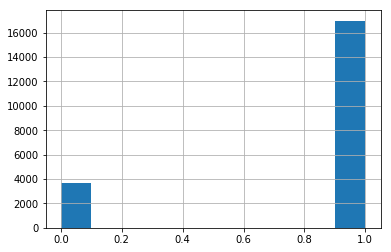

In [33]:
id_31 = df_Fraud['id_31']
id_31.isna().map({True:1,False:0}).hist()

The above histogram shows that there are more chances of fraud when browser information is not provided.

**11th GROUP** visulization

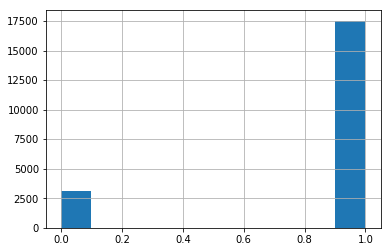

In [34]:
DeviceInfo = df_Fraud['DeviceInfo']
DeviceInfo.isna().map({True:1,False:0}).hist()

Same with Device Information also, more chances of fraud when Device Information is not provided.

In [35]:
# deleting those dataframe which are not in use to free memory
del df
del df_Fraud
del df_all
gc.collect()

0

**10th GROUP** encoding

In [36]:
merge['id_31'].unique().tolist()

['samsung browser 6.2',
 'mobile safari 11.0',
 'chrome 62.0',
 nan,
 'chrome 62.0 for android',
 'edge 15.0',
 'mobile safari generic',
 'chrome 49.0',
 'chrome 61.0',
 'edge 16.0',
 'safari generic',
 'edge 14.0',
 'chrome 56.0 for android',
 'firefox 57.0',
 'chrome 54.0 for android',
 'mobile safari uiwebview',
 'chrome',
 'chrome 62.0 for ios',
 'firefox',
 'chrome 60.0 for android',
 'mobile safari 10.0',
 'chrome 61.0 for android',
 'ie 11.0 for desktop',
 'ie 11.0 for tablet',
 'mobile safari 9.0',
 'chrome generic',
 'other',
 'chrome 59.0 for android',
 'firefox 56.0',
 'android webview 4.0',
 'chrome 55.0',
 'opera 49.0',
 'ie',
 'chrome 55.0 for android',
 'firefox 52.0',
 'chrome 57.0 for android',
 'chrome 56.0',
 'chrome 46.0 for android',
 'chrome 58.0',
 'firefox 48.0',
 'chrome 59.0',
 'samsung browser 4.0',
 'edge 13.0',
 'chrome 53.0 for android',
 'chrome 58.0 for android',
 'chrome 60.0',
 'mobile safari 8.0',
 'firefox generic',
 'Generic/Android 7.0',
 'mobile',

There are so many unique values in id_31(Browser Information) columns.

Now I am creating a dictionary to map id_31 column.
I am replacing full browser name with short name and browser version as you can see below

In [37]:
browser_dict = {
 'samsung browser 6.2':'samsung 6.2',
 'mobile safari 11.0':'safari 11.0',
 'chrome 62.0':'chrome 62',
 'chrome 62.0 for android':'chrome 62',
 'edge 15.0':'edge 15',
 'mobile safari generic':'safari 0',
 'chrome 49.0':'chrome 49',
 'chrome 61.0':'chrome 61',
 'edge 16.0':'edge 16',
 'safari generic':'safari 0',
 'edge 14.0':'edge 14',
 'chrome 56.0 for android':'chrome 56',
 'firefox 57.0':'firefox 57',
 'chrome 54.0 for android':'chrome 54',
 'mobile safari uiwebview':'safari 0',
 'chrome':'chrome 0',
 'chrome 62.0 for ios':'chrome 62',
 'firefox':'firefox 0',
 'chrome 60.0 for android':'chrome 60',
 'mobile safari 10.0':'safari 10',
 'chrome 61.0 for android':'chrome 61',
 'ie 11.0 for desktop':'ie 11',
 'ie 11.0 for tablet':'ie 11',
 'mobile safari 9.0':'safari 9',
 'chrome generic':'chrome 0',
 'other':'other 0',
 'chrome 59.0 for android':'chrome 59',
 'firefox 56.0':'firefox 56',
 'android webview 4.0':'webview 4',
 'chrome 55.0':'chrome 55',
 'opera 49.0':'opera 49',
 'ie':'ie 0',
 'chrome 55.0 for android':'chrome 55',
 'firefox 52.0':'firefox 52',
 'chrome 57.0 for android':'chrome 57',
 'chrome 56.0':'chrome 56',
 'chrome 46.0 for android':'chrome 46',
 'chrome 58.0':'chrome 58',
 'firefox 48.0':'firefox 48',
 'chrome 59.0':'chrome 59',
 'samsung browser 4.0':'samsung 4',
 'edge 13.0':'edge 13',
 'chrome 53.0 for android':'chrome 53',
 'chrome 58.0 for android':'chrome 58',
 'chrome 60.0':'chrome 60',
 'mobile safari 8.0':'safari 8',
 'firefox generic':'firefox 0',
 'Generic/Android 7.0':'Generic 7',
 'mobile':'mobile 0',
 'Samsung/SM-G532M':'samsung 0',
 'chrome 50.0 for android':'chrome 50',
 'chrome 51.0 for android':'chrome 51',
 'chrome 63.0':'chrome 63',
 'chrome 52.0 for android':'chrome 52',
 'chrome 51.0':'chrome 51',
 'firefox 55.0':'firefox 55',
 'edge':'edge 0',
 'opera':'opera 0',
 'chrome generic for android':'chrome 0',
 'aol':'aol 0',
 'samsung browser 5.4':'samsung 5.4',
 'Samsung/SCH':'samsung 0',
 'silk':'silk 0',
 'chrome 57.0':'chrome 57',
 'firefox 47.0':'firefox 47',
 'chrome 63.0 for android':'chrome 63',
 'Samsung/SM-G531H':'samsung 0',
 'chrome 43.0 for android':'chrome 43',
 'waterfox':'waterfox 0',
 'Nokia/Lumia':'Nokia 0',
 'chrome 63.0 for ios':'chrome 63',
 'puffin':'puffin 0',
 'Microsoft/Windows':'Windows 0',
 'cyberfox':'cyberfox 0',
 'Generic/Android':'Generic 0',
 'samsung':'samsung 0',
 'opera generic':'opera 0',
 'chrome 49.0 for android':'chrome 49',
 'ZTE/Blade':'ZTE 0',
 'safari':'safari 0',
 'android browser 4.0':'android 4',
 'samsung browser 5.2':'samsung 5.2',
 'palemoon':'palemoon 0',
 'maxthon':'maxthon 0',
 'line':'line 0',
 'LG/K-200':'LG 0',
 'iron':'iron 0',
 'BLU/Dash':'BLU 0',
 'seamonkey':'seamonkey 0',
 'firefox 58.0':'firefox 58',
 'chrome 64.0 for android':'chrome 64',
 'chrome 64.0':'chrome 64',
 'firefox 59.0':'firefox 59',
 'chrome 64.0 for ios':'chrome 64',
 'M4Tel/M4':'M4Tel 0',
 'comodo':'comodo 0',
 'Lanix/Ilium':'Lanix 0',
 'samsung browser generic':'samsung 0',
 'chromium':'chromium 0',
 'opera 51.0':'opera 51',
 'Inco/Minion':'Inco 0',
 'samsung browser 7.0':'samsung 7',
 'Mozilla/Firefox':'firefox 0',
 'samsung browser 4.2':'samsung 4.2',
 'samsung browser 6.4':'samsung 6.4',
 'chrome 65.0':'chrome 65',
 'chrome 65.0 for android':'chrome 65',
 'chrome 65.0 for ios':'chrome 65',
 'Cherry':'Cherry 0',
 'icedragon':'icedragon 0',
 'android':'android 0',
 'edge 17.0':'edge 17',
 'chrome 66.0':'chrome 66',
 'chrome 66.0 for android':'chrome 66',
 'safari 11.0':'safari 11',
 'safari 9.0':'safari 9',
 'safari 10.0':'safari 10',
 'google':'google 0',
 'chrome 66.0 for ios':'chrome 66',
 'google search application 48.0':'google 48',
 'opera 52.0':'opera 52',
 'firefox 60.0':'firefox 60',
 'opera 53.0':'opera 53',
 'samsung browser 3.3':'samsung 3.3',
 'google search application 49.0':'google 49',
 'facebook':'facebook 0',
 'firefox mobile 61.0':'firefox 61',
 'chrome 67.0':'chrome 67',
 'chrome 69.0':'chrome 69',
 'chrome 67.0 for android':'chrome 67',
 'firefox 61.0':'firefox 61',
 'samsung browser 7.2':'samsung 7.2',
 'chrome 67.0 for ios':'chrome 67',
 'google search application 52.0':'google 52',
 'firefox 62.0':'firefox 62',
 'mobile safari 12.0':'safari 12',
 'chrome 68.0':'chrome 68',
 'opera 54.0':'opera 54',
 'firefox mobile 62.0':'firefox 62',
 'google search application 54.0':'google 54',
 'safari 12.0':'safari 12',
 'chrome 68.0 for android':'chrome 68',
 'chrome 68.0 for ios':'chrome 68',
 'chrome 39.0 for android':'chrome 39',
 'chrome 70.0':'chrome 70',
 'rim':'rim 0',
 'chrome 69.0 for android':'chrome 69',
 'google search application 56.0':'google 56',
 'samsung browser 7.4':'samsung 7.4',
 'opera 55.0':'opera 55',
 'firefox 63.0':'firefox 63',
 'google search application 58.0':'google 58',
 'chrome 69.0 for ios':'chrome 69',
 'chrome 70.0 for android':'chrome 70',
 'uc':'uc 0',
 'google search application 59.0':'google 59',
 'opera 56.0':'opera 56',
 'chrome 71.0':'chrome 71',
 'google search application 60.0':'google 60',
 'edge 18.0':'edge 18',
 'chrome 70.0 for ios':'chrome 70',
 'firefox mobile 63.0':'firefox 63',
 'google search application 61.0':'google 61',
 'firefox 64.0':'firefox 64',
 'google search application 62.0':'google 62',
 'chrome 71.0 for android':'chrome 71',
 'google search application 63.0':'google 63',
 'chrome 71.0 for ios':'chrome 71',
 'google search application 64.0':'google 64',
 'samsung browser 8.2':'samsung 8.2',
 'google search application 65.0':'google 65',
 'blackberry':'blackberry 0'
    
}

**Applying mapping **

In [38]:
merge['id_31'] = merge['id_31'].map(browser_dict)

del browser_dict
gc.collect()

0

Now again printing unique values in id_31 column

In [39]:
merge['id_31'].unique()

array(['samsung 6.2', 'safari 11.0', 'chrome 62', nan, 'edge 15',
       'safari 0', 'chrome 49', 'chrome 61', 'edge 16', 'edge 14',
       'chrome 56', 'firefox 57', 'chrome 54', 'chrome 0', 'firefox 0',
       'chrome 60', 'safari 10', 'ie 11', 'safari 9', 'other 0',
       'chrome 59', 'firefox 56', 'webview 4', 'chrome 55', 'opera 49',
       'ie 0', 'firefox 52', 'chrome 57', 'chrome 46', 'chrome 58',
       'firefox 48', 'samsung 4', 'edge 13', 'chrome 53', 'safari 8',
       'Generic 7', 'mobile 0', 'samsung 0', 'chrome 50', 'chrome 51',
       'chrome 63', 'chrome 52', 'firefox 55', 'edge 0', 'opera 0',
       'aol 0', 'samsung 5.4', 'silk 0', 'firefox 47', 'chrome 43',
       'waterfox 0', 'Nokia 0', 'puffin 0', 'Windows 0', 'cyberfox 0',
       'Generic 0', 'ZTE 0', 'android 4', 'samsung 5.2', 'palemoon 0',
       'maxthon 0', 'line 0', 'LG 0', 'iron 0', 'BLU 0', 'seamonkey 0',
       'firefox 58', 'chrome 64', 'firefox 59', 'M4Tel 0', 'comodo 0',
       'Lanix 0', 'chromium 

Now splitting browser name and browser version 

In [40]:
id_31_split = merge['id_31'].str.split(' ',n=1,expand = True)

Now creating two new column in merge dataset to store browser_name and browser_version and deleting id_31 column from merge dataset.

In [41]:
merge['browser_name'] = id_31_split[0]
merge['browser_version'] = id_31_split[1]

merge = merge.drop('id_31',axis = 1)

del id_31_split
gc.collect()

11

In [42]:
merge.head()

,TransactionID_x,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_28,id_29,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,browser_name,browser_version
0,2987000,86400,68.5,5,13926,NaN,150.0,1.0,142.0,1.0,...,1.0,0,1,0,1,1,1,SAMSUNG SM-G892A Build/NRD90M,samsung,6.2
1,2987001,86401,29.0,5,2755,404.0,150.0,2.0,102.0,1.0,...,1.0,0,1,0,0,1,1,iOS Device,safari,11.0
2,2987002,86469,59.0,5,4663,490.0,150.0,NaN,166.0,2.0,...,1.0,1,0,0,1,1,2,Windows,chrome,62
3,2987003,86499,50.0,5,18132,567.0,150.0,2.0,117.0,2.0,...,1.0,0,0,0,1,1,2,NaN,chrome,62
4,2987004,86506,50.0,2,4497,514.0,150.0,2.0,102.0,1.0,...,1.0,1,1,0,1,1,2,MacOS,chrome,62


In the above output you can see there are two new columns in the last.

In [43]:
merge.browser_name.unique()

array(['samsung', 'safari', 'chrome', nan, 'edge', 'firefox', 'ie',
       'other', 'webview', 'opera', 'Generic', 'mobile', 'aol', 'silk',
       'waterfox', 'Nokia', 'puffin', 'Windows', 'cyberfox', 'ZTE',
       'android', 'palemoon', 'maxthon', 'line', 'LG', 'iron', 'BLU',
       'seamonkey', 'M4Tel', 'comodo', 'Lanix', 'chromium', 'Inco',
       'Cherry', 'icedragon', 'google', 'facebook', 'rim', 'uc',
       'blackberry'], dtype=object)

Now creating dictionary to map browser_name column.

In [44]:
browser_name_dict = {
       'samsung':1, 'safari':2, 'chrome':3,'edge':4, 'firefox':5, 'ie':6,
       'other':7, 'webview':8, 'opera':9, 'Generic':10, 'mobile':11, 'aol':12, 'silk':13,
       'waterfox':14, 'Nokia':15, 'puffin':16, 'Windows':17, 'cyberfox':18, 'ZTE':19,
       'android':20, 'palemoon':21, 'maxthon':22, 'line':23, 'LG':24, 'iron':25, 'BLU':26,
       'seamonkey':27, 'M4Tel':28, 'comodo':29, 'Lanix':30, 'chromium':31, 'Inco':32,
       'Cherry':33, 'icedragon':34, 'google':35, 'facebook':36, 'rim':37, 'uc':38,
       'blackberry':39
}

**Applying mapping**

In [45]:
merge.browser_name = merge.browser_name.map(browser_name_dict)

del browser_name_dict
gc.collect()

0

In [46]:
merge.browser_name.unique()

array([ 1.,  2.,  3., nan,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39.])

**11th GROUP** encoding

Printing unique values in DeviceInfo column.

In [47]:
merge['DeviceInfo'].unique().tolist()

['SAMSUNG SM-G892A Build/NRD90M',
 'iOS Device',
 'Windows',
 nan,
 'MacOS',
 'SM-G930V Build/NRD90M',
 'BLADE A602 Build/MRA58K',
 'XT1635-02 Build/NPN26.118-22-2',
 'Z970',
 'SM-N920V Build/NRD90M',
 'Redmi Note 4 Build/MMB29M',
 'Lenovo PB1-750M Build/S100',
 'LT22i Build/6.2.A.1.100',
 'rv:52.0',
 'SM-G950U Build/NRD90M',
 'LG-H872 Build/NRD90U',
 'LG-K500 Build/MMB29M',
 'SM-P550 Build/MMB29M',
 'SM-J700M Build/MMB29K',
 'Trident/7.0',
 'rv:57.0',
 'SAMSUNG SM-G930T Build/NRD90M',
 'Blade V6 Plus Build/MRA58K',
 'BLL-L23 Build/HUAWEIBLL-L23',
 'KYOCERA-C6742A Build/LMY47V',
 'F3113 Build/33.2.A.4.70',
 'D5306 Build/19.4.A.0.182',
 'M4 SS4457 Build/MRA58K',
 'SM-G955U Build/NRD90M',
 'SM-G610M Build/MMB29K',
 'SAMSUNG SM-G935F Build/NRD90M',
 'XT1635-01',
 'rv:56.0',
 'VS500',
 'CAM-L03 Build/HUAWEICAM-L03',
 'RCT6303W87M7 Build/MRA58K',
 'M4 SS4451 Build/LMY47D',
 'KFFOWI Build/LVY48F',
 'Moto E (4) Build/NMA26.42-19',
 'SAMSUNG',
 'E2306 Build/26.3.A.1.33',
 'Ilium L910 Build/MRA

As we can see in the above output there are many model of devices from same company so first we have to group devices from same company.

Converting whole DeviceInfo column into String type because it contains some float values also.

In [48]:
merge['DeviceInfo'] = merge['DeviceInfo'].astype(str)

Now I am creating a dictionary of groups to replace device_name with company name.

=> A group contains some starting characters of device_names which are belong to same company.
    

In [49]:
Device_info_dict = {
                    'Samsung':('C5','SM','GT','RE','SC','SGH','SA','SP','S8','Gal','S9+'),
                    'iOS':('iO','iP','7_P'),
                    'Windows':('Wi'),
                    'Mac':('Ma'),
                    'ZTE':('BOI','Bl','ZT','K8','BLA','Z8','Z9','K90','Z7','N9','N8','E8','Z55'),
                    'MotoRola':('XT','Mo','mo'),
                    'Mi':('Re','Mi ','R1','MI','PO','201'),
                    'Lenovo':('Le','MO','S6','YO','Id','Tab'),
                    'Sony':('SO','H82','H83','H3','SOV','C1','Z2','T1','LT','F3','D5','E2','SGP','F5','E5','E6','G3','D6','F8','C2','G8','D2','C69','C66','C65'),
                    'other':('Ph','MB5','Sla','Q0','IM6','ROC','GHI','M5','HS2','RID','Lif','R50','a50','N1','car','bre','KEM','Mir','NAT','RAI','A952','Tan','EN','GLA','i50','A7','Pow','IO','Sho','No','DO','MT','47','Dr','Swi','GR','H5','STE','LI','en','xs','Ad','91','SE','Jo','PL','10','U','rv','An','es','Ed','MD','MA','BO','Ne','To','Fr','WO','TR','S.N','VF','St','SL','or','Or','Qw','Inf','gx','Be','DA','INF','AKU','...'),
                    'LG':('LG','Tr','VS','VK','RS','LM','K10','L-03'),
                    'Huawei':('DIG','Che','PIC','HMA','JKM','P10','LYA','CMR','PAR','AGS','INE','DRA','SNE','FLA','LLD','VIE','LDN','ANE','Y55','CLT','EM','G52','FI','DL','DU','RN','NE','VT','G6','BLL','CA','TR','AL','WA','HU','BA','CH','Y6','EV','FR','PR','MY','SL','hi','MH','HI','CR','BLN','H1','BG'),
                    'Kyocera':('KY','C67'),
                    'M4Tel':('M4'),
                    'RCA':('RC'),
                    'Amazon':('KF'),
                    'Lanix':('Il'),
                    'Google':('Ne','Pi'),
                    'HTC':('HT','2P','Bu','0P','83'),
                    'Alcatel':('70','oN','50','Al','80','40','AL','90','A6','60','A4','92','A5'),
                    'Oppo':('R8','A1','F1','CP','R7'),
                    'Nokia':('TA','NO'),
                    'Acer':('Z4','S57','B1','B3','T0'),
                    'Polaroid':('P4','P5','PS','Tu','PMI','M10'),
                    'Hisense':('Hi'),
                    'Verizon':('QT','QM'),
                    'Aquaris':('Aq'),
                    'Branses & Noble':('BN'),
                    'OnePlus':('ON','A0'),
                    'Linux':('Lin','Fed'),
                    'Le':('Le','X900+','LE'),
                    'SwissMobility':('ZE','ZU'),
                    'Bmobile':('AX'),
                    'BlackView':('BV'),
                    'NextBook':('NX'),
                    'Microsoft':('Microsoft','Lum'),
                    'SKY':('SK'),
                    'Lava':('X10','A3','FP','LA','ir','Gr','A97'),
                    'VeryKool':('Ver','ver'),
                    'Wiko':('TO','PU','FEV'),
                    'Helio':('HE'),
                    'AT&T':('AT'),
                    'BlackBerry':('BB','STV','RIM'),
                    'HP':('hp','HP'),
                    'Essential':('PH'),
                    'M3':('m3'),
                    'Asus':('P0','ME','AS','K01'),
                    'T-Mobile':('REV'),
                    'VSN':('V.4'),
                    'BLU':('BLU','En','R2','STU'),
                    'Sharp':('SH'),
                    'Hyundai':('Ven','G25','G24'),
                    'CoolPad':('Co'),
                    'Vivo':('Vi','vi'),
                    'Azumi':('A50','Az'),
                    'Intel':('Int'),
                    'Kechao':('K92'),
                    'Honor':('KI','PE','BKL','AUM'),
                    'Micromax':('X78','Micromax'),
                    'Ampe':('A96'),
                    'Denali':('DT'),
                    'Archos':('Ar'),
                    'Freetel':('FT'),
                    'e.GO':('EGO'),
                    'NextBit':('Ro'),
                    'Icon':('IC'),
                    'Zuum':('CO'),
                    'Dash':('Da'),
                    'Tmovi':('Tm'),
                    'Zonda':('ZA'),
                    'Logic':('LO'),
                    'Azimuth':('S70'),
                    'Zumm':('ZU'),
                    'Xphone':('X34'),
                    'STK':('STK'),
                    'NYX':('NY'),
                    'Helix':('He'),
                    'AOC':('AOC'),
                    'Gigaset':('Gi'),
                    'Vios':('V5'),
                    'STF':('STF','AE'),
                    'Kylin':('Ky'),
                    'Amgoo':('AM'),
                    'Techberry':('Te'),
                    'Fusion5':('Fu'),
                    'Shift':('Shi'),
                    'Bolt':('Bol'),
                    'Senwa':('S47','LS'),
                    'Orion':('OR'),
                    'Touch':('TU'),
                    'Weimei':('we'),
                    'Vorago':('VO'),
                    'Cubot':('CU'),
                    'Astro':('As'),
                    'Arc':('arc'),
                    'Yuho':('O1'),
                    'Aiwa':('AW'),
                    'UMX':('MXG'),
                    'AcTek':('HK'),
                    'NUU':('N5'),
                    'Zebra':('Zeb'),
                    'Karbonn':('au')
                    }

In [50]:
device = merge['DeviceInfo'].copy()
device

0         SAMSUNG SM-G892A Build/NRD90M
1                            iOS Device
2                               Windows
3                                   nan
4                                 MacOS
                      ...              
506686                              nan
506687                              nan
506688                              nan
506689                              nan
506690                              nan
Name: DeviceInfo, Length: 1097231, dtype: object

**Applying mapping**

In [51]:
for x,y in Device_info_dict.items():
    device[device.str.startswith(y)] = x
    
print(device)
del Device_info_dict
gc.collect()

0         Samsung
1             iOS
2         Windows
3             nan
4             Mac
           ...   
506686        nan
506687        nan
506688        nan
506689        nan
506690        nan
Name: DeviceInfo, Length: 1097231, dtype: object


0

In [52]:
device.unique().tolist()

['Samsung',
 'iOS',
 'Windows',
 'nan',
 'Mac',
 'ZTE',
 'MotoRola',
 'Mi',
 'Le',
 'Sony',
 'other',
 'LG',
 'Huawei',
 'Kylin',
 'M4Tel',
 'RCA',
 'Amazon',
 'Lanix',
 'HTC',
 'Alcatel',
 'OnePlus',
 'Oppo',
 'Nokia',
 'Google',
 'Acer',
 'Polaroid',
 'Hisense',
 'VeryKool',
 'Aquaris',
 'Branses & Noble',
 'Linux',
 'SwissMobility',
 'Bmobile',
 'BlackView',
 'NextBook',
 'Microsoft',
 'Lava',
 'ILIUM',
 'SKY',
 'BlackBerry',
 'Wiko',
 'Helix',
 'AT&T',
 'HP',
 'Essential',
 'M3',
 'Astro',
 'VSN',
 'BLU',
 'Sharp',
 'Hyundai',
 'CoolPad',
 'Vivo',
 'Intel',
 'Kechao',
 'Honor',
 'Ampe',
 'A9',
 'Denali',
 'Archos',
 'Freetel',
 'e.GO',
 'NextBit',
 'Icon',
 'Zuum',
 'Dash',
 'Tmovi',
 'Zonda',
 'Logic',
 'STF',
 'Azimuth',
 'Minion_Tab',
 'Yuho',
 'Xphone',
 'STK',
 'NYX',
 'AOC',
 'Gigaset',
 'Vios',
 'Z',
 'Amgoo',
 'Techberry',
 'Fusion5',
 'Micromax',
 'Shift',
 'Bolt',
 'Senwa',
 'Azumi',
 'Orion',
 'Touch',
 'Weimei',
 'Vorago',
 'Cubot',
 'Arc',
 'Aiwa',
 '8_Plus',
 'UMX',
 

Now creating a dictionary to encode company name with integers.

In [53]:
device_name_encode_dict = { 'nan':0,'Samsung':1,'iOS':2,'Windows':3,'Mac':4,'ZTE':5,'MotoRola':6,'Mi':7,
                            'Le':8,'Sony':9,'other':10,'LG':11,'Huawei':12,'Kylin':13,'M4Tel':14,'RCA':15,
                            'Amazon':16,'Lanix':17,'HTC':18,'Alcatel':19,'OnePlus':20,'Oppo':21,'Nokia':22,
                            'Google':23,'Acer':24,'Polaroid':25,'Hisense':26,'VeryKool':27,'Aquaris':28,
                            'Branses & Noble':29,'Linux':30,'SwissMobility':31,'Bmobile':32,'BlackView':33,
                            'NextBook':34,'Microsoft':35,'Lava':36,'ILIUM':37,'SKY':38,'BlackBerry':40,
                            'Wiko':41,'Helix':42,'AT&T':43,'HP':44,'Essential':45,'M3':46,'Astro':47,
                            'VSN':48,'BLU':49,'Sharp':50,'Hyundai':51,'CoolPad':52,'Vivo':53,'Intel':54,
                            'Kechao':55,'Honor':56,'Ampe':57,'A9':60,'Denali':61,'Archos':62,'Freetel':63,
                            'e.GO':64,'NextBit':65,'Icon':66,'Zuum':67,'Dash':68,'Tmovi':69,'Zonda':70,
                            'Logic':71,'STF':72,'Azimuth':73,'Minion_Tab':74,'Yuho':75,'Xphone':76,
                            'STK':77,'NYX':78,'AOC':79,'Gigaset':80,'Vios':81,'Z':82,'Amgoo':83,
                            'Techberry':84,'Fusion5':85,'Micromax':86,'Shift':87,'Bolt':88,'Senwa':89,
                            'Azumi':90,'Orion':91,'Touch':92,'Weimei':93,'Vorago':94,'Cubot':95,'Arc':96,
                            'Aiwa':97,'8_Plus':98,'UMX':99,'AcTek':100,'NUU':101,'Zebra':102,'Karbonn':103
                            }

**Applying mapping**

In [54]:
device = device.map(device_name_encode_dict)
print(device)
del device_name_encode_dict
gc.collect()

0         1
1         2
2         3
3         0
4         4
         ..
506686    0
506687    0
506688    0
506689    0
506690    0
Name: DeviceInfo, Length: 1097231, dtype: int64


0

In [55]:
device.unique()

array([  1,   2,   3,   0,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103])

In [56]:
merge['DeviceInfo'] = device

del device
gc.collect()

0

In [57]:
merge['DeviceInfo']

0         1
1         2
2         3
3         0
4         4
         ..
506686    0
506687    0
506688    0
506689    0
506690    0
Name: DeviceInfo, Length: 1097231, dtype: int64

**Now encoding of R_email and P_email columns using label encoder...**

In [58]:
merge['R_emaildomain'] = merge['R_emaildomain'].astype(str)
R_eml = merge['R_emaildomain'].copy()

In [59]:
merge['P_emaildomain'] = merge['P_emaildomain'].astype(str)
P_eml = merge['P_emaildomain'].copy()

In [60]:
P_eml[P_eml == 'nan'] = 0

In [61]:
R_eml[R_eml == 'nan'] = 0

In [62]:
LblEnc = preprocessing.LabelEncoder()
P_eml[P_eml != 0] = LblEnc.fit_transform(P_eml[P_eml != 0])+1
R_eml[R_eml != 0] = LblEnc.fit_transform(R_eml[R_eml != 0])+1

In [63]:
P_eml

0          0
1         17
2         36
3         55
4         17
          ..
506686    17
506687    20
506688    20
506689    20
506690    20
Name: P_emaildomain, Length: 1097231, dtype: object

In [64]:
merge['P_emaildomain'] = P_eml
merge['R_emaildomain'] = R_eml

del P_eml
del R_eml
gc.collect()

0

In [65]:
merge['browser_version'] = merge['browser_version'].astype(float)

In [66]:
merge['DeviceInfo'][merge['DeviceInfo']==0] = np.NaN

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
merge['R_emaildomain'][merge['R_emaildomain']==0] = np.NaN
merge['P_emaildomain'][merge['P_emaildomain']==0] = np.NaN

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Handling of missing values**

=> I am replacing NaN values with -999

In [68]:
for col in merge.columns:
    merge[col] = merge[col].astype(float)
    
#merge = merge.fillna(-999)

In [69]:
train = merge[merge['TransactionID_x'].isin(train_Tran_ID.tolist())]
test = merge[merge['TransactionID_x'].isin(test_Tran_ID.tolist())]

In [70]:
del merge
gc.collect()

0

In [71]:
print(train_len)
print(test_len)

590540
506691


In [72]:
print(train.TransactionDT.min())
print(train.TransactionDT.max())
print(test.TransactionDT.min())
print(test.TransactionDT.max())

86400.0
15811131.0
18403224.0
34214345.0


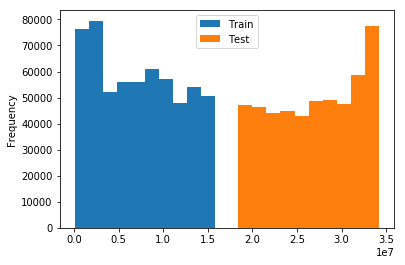

In [73]:
train['TransactionDT'].plot(kind='hist',label='Train',legend=True)
test['TransactionDT'].plot(kind='hist',label='Test',legend=True)

**Creating new features from TransactionDT column.**

In [74]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [75]:
train_target = pd.concat([train,target],axis = 1)

In [76]:
train_target = train_target.sort_values(by='TransactionDT')
test = test.sort_values(by='TransactionDT')

In [77]:
target = train_target['isFraud']
train = train_target.drop('isFraud',axis = 1)

del train_target
gc.collect()

54

In [78]:
train['TransactionAmt_decimal'] = ((train['TransactionAmt']
                                    - train['TransactionAmt'].astype(int)) * 1000).astype(int)

test['TransactionAmt_decimal'] = ((test['TransactionAmt'] 
                                   - test['TransactionAmt'].astype(int)) * 1000).astype(int)


In [79]:
sort_train_tranID = train['TransactionID_x'].copy()
sort_test_tranID = test['TransactionID_x'].copy()

train = train.drop(['TransactionID_x','TransactionID_y'],axis = 1)
test = test.drop(['TransactionID_x','TransactionID_y'],axis = 1)

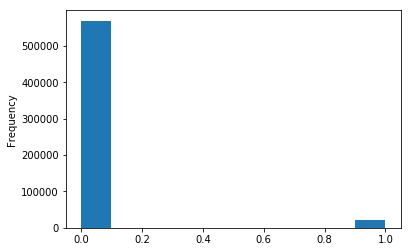

In [80]:
target.plot(kind = 'hist')

In [81]:
Fraud_counts = len(target[target == 1])

In [82]:
train_target = pd.concat([train,target],axis = 1)
Fraud = train_target[train_target['isFraud']==1]
Non_Fraud = train_target[train_target['isFraud']==0]

In [83]:
del train_target
gc.collect()

0

In [84]:
sampled_Non_fraud = Non_Fraud.sample(Fraud_counts)
sampled_Non_fraud

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_37,id_38,DeviceType,DeviceInfo,browser_name,browser_version,Transaction_day_of_week,Transaction_hour,TransactionAmt_decimal,isFraud
361895,8975653.0,117.000,5.0,7234.0,122.0,150.0,2.0,126.0,2.0,181.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,21.0,0,0
433466,10959797.0,70.000,5.0,5815.0,268.0,150.0,NaN,166.0,2.0,433.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,20.0,0,0
557453,14752674.0,34.000,5.0,15484.0,418.0,150.0,NaN,226.0,2.0,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,0,0
31960,782587.0,87.000,5.0,11207.0,361.0,150.0,NaN,226.0,2.0,325.0,...,0.0,0.0,2.0,4.0,2.0,0.0,1.0,1.0,0,0
182070,4034531.0,50.000,4.0,2713.0,555.0,117.0,2.0,177.0,2.0,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,16.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381912,9568604.0,150.000,3.0,4577.0,583.0,150.0,2.0,219.0,1.0,264.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,17.0,0,0
371302,9236331.0,125.000,3.0,16253.0,520.0,150.0,3.0,190.0,1.0,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.0,0,0
55927,1294340.0,20.875,1.0,13789.0,103.0,185.0,NaN,226.0,1.0,NaN,...,0.0,1.0,1.0,2.0,2.0,10.0,6.0,23.0,875,0
390331,9804568.0,100.000,3.0,11905.0,162.0,150.0,NaN,226.0,2.0,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.0,0,0


In [85]:
sampled_train = pd.concat([sampled_Non_fraud,Fraud],axis = 0)

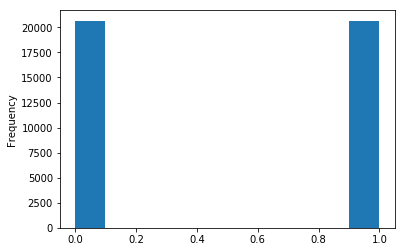

In [86]:
sampled_train['isFraud'].plot(kind = 'hist')

In [87]:
sampled_train = sampled_train.sort_values(by = 'TransactionDT')
X = sampled_train.drop('isFraud',axis = 1)
Y = sampled_train.isFraud

In [88]:
X = X.reset_index(drop = True)
Y = Y.reset_index(drop = True)

In [89]:
#from sklearn.manifold import TSNE

#X_reduced_tsne = TSNE(n_components=2,random_state=42).fit_transform(X.values)

In [90]:
#temp = X_reduced_tsne.copy()

In [91]:
#temp = pd.DataFrame(temp)

In [92]:
#temp = pd.concat([temp,Y],axis = 1)

In [93]:
#temp.columns = ['x','y','isFraud']
#temp

In [94]:
#sns.scatterplot(x = 'x' ,y= 'y',hue = 'isFraud', data=temp)

In [95]:
del sampled_Non_fraud
del sampled_train
del Fraud

gc.collect()

13

In [96]:
X = X.drop('TransactionDT',axis = 1)
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_36,id_37,id_38,DeviceType,DeviceInfo,browser_name,browser_version,Transaction_day_of_week,Transaction_hour,TransactionAmt_decimal
0,30.000000,5.0,2392.0,360.0,150.0,2.0,166.0,2.0,269.0,87.0,...,1.0,1.0,1.0,2.0,11.0,6.0,11.0,0.0,0.0,0
1,445.000000,5.0,18268.0,583.0,150.0,NaN,226.0,1.0,251.0,87.0,...,0.0,1.0,1.0,2.0,3.0,3.0,62.0,0.0,0.0,0
2,15.000000,2.0,6019.0,583.0,150.0,NaN,226.0,1.0,264.0,87.0,...,0.0,1.0,1.0,1.0,6.0,3.0,62.0,0.0,0.0,0
3,67.937500,5.0,16075.0,514.0,150.0,2.0,102.0,1.0,264.0,87.0,...,0.0,1.0,0.0,2.0,3.0,3.0,62.0,0.0,0.0,937
4,37.093750,1.0,13413.0,103.0,185.0,NaN,137.0,1.0,NaN,NaN,...,0.0,1.0,1.0,1.0,NaN,2.0,0.0,0.0,1.0,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,107.937500,5.0,14290.0,512.0,150.0,NaN,226.0,2.0,225.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,937
41322,30.953125,5.0,6489.0,295.0,150.0,NaN,226.0,2.0,494.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,953
41323,67.937500,5.0,10447.0,490.0,150.0,NaN,226.0,2.0,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,937
41324,380.000000,5.0,2616.0,327.0,150.0,1.0,102.0,1.0,299.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,0


In [97]:
train = train.drop('TransactionDT',axis = 1)
train

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_36,id_37,id_38,DeviceType,DeviceInfo,browser_name,browser_version,Transaction_day_of_week,Transaction_hour,TransactionAmt_decimal
0,68.500000,5.0,13926.0,NaN,150.0,1.0,142.0,1.0,315.0,87.0,...,0.0,1.0,1.0,1.0,1.0,1.0,6.2,0.0,0.0,500
1,29.000000,5.0,2755.0,404.0,150.0,2.0,102.0,1.0,325.0,87.0,...,0.0,0.0,1.0,1.0,2.0,2.0,11.0,0.0,0.0,0
2,59.000000,5.0,4663.0,490.0,150.0,NaN,166.0,2.0,330.0,87.0,...,0.0,1.0,1.0,2.0,3.0,3.0,62.0,0.0,0.0,0
3,50.000000,5.0,18132.0,567.0,150.0,2.0,117.0,2.0,476.0,87.0,...,0.0,1.0,1.0,2.0,NaN,3.0,62.0,0.0,0.0,0
4,50.000000,2.0,4497.0,514.0,150.0,2.0,102.0,1.0,420.0,87.0,...,0.0,1.0,1.0,2.0,4.0,3.0,62.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.000000,5.0,6550.0,NaN,150.0,NaN,226.0,2.0,272.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,0
590536,39.500000,5.0,10444.0,225.0,150.0,2.0,224.0,2.0,204.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,500
590537,30.953125,5.0,12037.0,595.0,150.0,2.0,224.0,2.0,231.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,953
590538,117.000000,5.0,7826.0,481.0,150.0,2.0,224.0,2.0,387.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,23.0,0


In [98]:
target.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [99]:
#cat_cols = ['M2','M3','M5','M6','M7','M8','M9','id_35','id_36','id_37','id_38','id_12','id_16',
#            'id_29','ProductCD','card6','card4','DeviceType','M4','id_15','id_28','browser_name',
#            'DeviceInfo','P_emaildomain','R_emaildomain']

In [100]:
#for col in cat_cols:
#    X[col] = X[col].astype(str)

In [101]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
                            iterations = 1000,
                            learning_rate = 0.06,
                            custom_loss=['AUC'],
                            loss_function = "Logloss",
                            eval_metric="AUC",
                            has_time = True,
                            nan_mode = "Min",
                            thread_count = -1,
                            verbose = 50,
                            metric_period = 50,
                            scale_pos_weight = 27.5
                            )

In [102]:
from catboost import Pool, cv

cv_dataset = Pool(
                   data = train,
                   label = target
                    )
params = {
           "learning_rate":0.06,
           "loss_function":'Logloss',
           "custom_metric": ['AUC'],
           "eval_metric": 'AUC',
           "has_time" : True,
           "nan_mode" : "Min",
           "scale_pos_weight":27.5
}


scores = cv( 
             pool = cv_dataset,
             params = params,
             iterations = 1500,
             type = 'TimeSeries',
             plot = True,
             #metric_period = 100,
             verbose = 10,
             early_stopping_rounds = 70,
             fold_count = 5
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8076070	best: 0.8076070 (0)	total: 2.38s	remaining: 59m 21s
10:	test: 0.8511157	best: 0.8511157 (10)	total: 19.9s	remaining: 44m 54s
20:	test: 0.8575950	best: 0.8575950 (20)	total: 38.7s	remaining: 45m 23s
30:	test: 0.8617738	best: 0.8617738 (30)	total: 56.5s	remaining: 44m 39s
40:	test: 0.8649874	best: 0.8649874 (40)	total: 1m 15s	remaining: 44m 31s
50:	test: 0.8674951	best: 0.8674951 (50)	total: 1m 32s	remaining: 43m 42s
60:	test: 0.8702763	best: 0.8702763 (60)	total: 1m 49s	remaining: 43m 8s
70:	test: 0.8721483	best: 0.8721483 (70)	total: 2m 7s	remaining: 42m 48s
80:	test: 0.8735437	best: 0.8735437 (80)	total: 2m 24s	remaining: 42m 10s
90:	test: 0.8749746	best: 0.8749746 (90)	total: 2m 42s	remaining: 41m 57s
100:	test: 0.8760947	best: 0.8760947 (100)	total: 3m	remaining: 41m 33s
110:	test: 0.8773933	best: 0.8773933 (110)	total: 3m 17s	remaining: 41m 13s
120:	test: 0.8783384	best: 0.8783384 (120)	total: 3m 35s	remaining: 40m 54s
130:	test: 0.8791287	best: 0.8791287 (130)	t

In [103]:
print(scores)

     iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
0             0       0.807607      0.023757           0.667632   
1             1       0.827885      0.007511           0.645470   
2             2       0.836046      0.013912           0.626052   
3             3       0.838369      0.012959           0.609691   
4             4       0.842809      0.011043           0.596080   
..          ...            ...           ...                ...   
794         794       0.894018      0.021434           0.477730   
795         795       0.894033      0.021410           0.477686   
796         796       0.894048      0.021382           0.477775   
797         797       0.894068      0.021348           0.477811   
798         798       0.894039      0.021369           0.477913   

     test-Logloss-std  train-Logloss-mean  train-Logloss-std  
0            0.003268            0.666413           0.001531  
1            0.003920            0.643202           0.001089  
2     

In [104]:
from catboost import Pool

train_pool = Pool( data = train,
                   label = target 
                    )
model.fit(train_pool, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 616ms	remaining: 10m 14s
50:	total: 32.4s	remaining: 10m 1s
100:	total: 1m 3s	remaining: 9m 23s
150:	total: 1m 34s	remaining: 8m 50s
200:	total: 2m 5s	remaining: 8m 18s
250:	total: 2m 37s	remaining: 7m 49s
300:	total: 3m 10s	remaining: 7m 22s
350:	total: 3m 41s	remaining: 6m 49s
400:	total: 4m 12s	remaining: 6m 16s
450:	total: 4m 42s	remaining: 5m 44s
500:	total: 5m 12s	remaining: 5m 11s
550:	total: 5m 43s	remaining: 4m 39s
600:	total: 6m 14s	remaining: 4m 8s
650:	total: 6m 44s	remaining: 3m 36s
700:	total: 7m 14s	remaining: 3m 5s
750:	total: 7m 45s	remaining: 2m 34s
800:	total: 8m 15s	remaining: 2m 3s
850:	total: 8m 46s	remaining: 1m 32s
900:	total: 9m 16s	remaining: 1m 1s
950:	total: 9m 47s	remaining: 30.3s
999:	total: 10m 16s	remaining: 0us


In [105]:
test = test.drop('TransactionDT',axis = 1)
prediction = model.predict_proba(test)
prediction[:,1]

array([0.02302938, 0.06253833, 0.09922892, ..., 0.16653411, 0.21477713,
       0.18841324])

In [106]:
prediction = prediction[:,1]
pred_df = pd.concat([sort_test_tranID,pd.DataFrame(prediction)],axis =1)

In [107]:
pred_df

,TransactionID_x,0
0,3663549.0,0.023029
1,3663550.0,0.062538
2,3663551.0,0.099229
3,3663552.0,0.030458
4,3663553.0,0.025944
...,...,...
506686,4170235.0,0.377786
506687,4170236.0,0.145076
506688,4170237.0,0.166534
506689,4170238.0,0.214777


In [108]:
submission = pd.merge(pd.DataFrame(test_Tran_ID),pred_df,how = 'left', on = 'TransactionID_x')

In [109]:
submission.columns = ['TransactionID','isFraud']
submission

,TransactionID,isFraud
0,3663549,0.023029
1,3663550,0.062538
2,3663551,0.099229
3,3663552,0.030458
4,3663553,0.025944
...,...,...
506686,4170235,0.377786
506687,4170236,0.145076
506688,4170237,0.166534
506689,4170238,0.214777


In [110]:
submission.to_csv('submission1.csv',index = False)